In [0]:
!rm -rf *

In [2]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2018-04-24 13:58:03--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.35
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.74.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  5.06MB/s    in 6.1s    

2018-04-24 13:58:09 (4.14 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2018-04-24 13:58:11--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.11
Connecting to fashion-mnist.s3-website.eu-central-1.amazona

In [0]:
!mkdir MNIST_Fashion; cp *.gz MNIST_Fashion/

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

(1, 784)


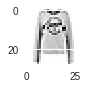

In [6]:
plt.figure(figsize=(1,1))
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

In [0]:
def discriminator(images, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()

    # First convolutional and pool layers
    # This finds 32 different 5 x 5 pixel features
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    d1 = d1 + d_b1
    d1 = tf.nn.relu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Second convolutional and pool layers
    # This finds 64 different 5 x 5 pixel features
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # First fully connected layer
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)

    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4

    # d4 contains unscaled values
    return d4

In [0]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [0]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [0]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

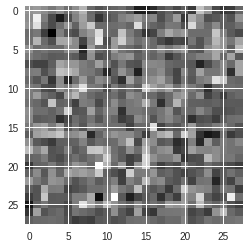

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

In [0]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse=True)
# Dg will hold discriminator prediction probabilities for generated images

In [0]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

In [0]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg,labels=tf.ones_like(Dg)))

In [15]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


In [0]:
# Train the discriminator
with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE) as scope:
  d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
  d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

  # Train the generator
  g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [0]:
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

dLossReal: 0.6955492 dLossFake: 0.72070146
dLossReal: 0.21841699 dLossFake: 0.65536666
dLossReal: 0.0136090545 dLossFake: 0.031510197
Iteration: 0 at 2018-04-24 13:59:04.964594


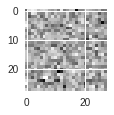

Estimate: [[-6.586551]]
Iteration: 100 at 2018-04-24 13:59:10.106391


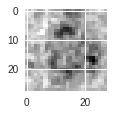

Estimate: [[-2.5233805]]
Iteration: 200 at 2018-04-24 13:59:15.250921


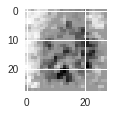

Estimate: [[-3.6612923]]
Iteration: 300 at 2018-04-24 13:59:20.393205


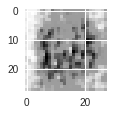

Estimate: [[-1.3216902]]
Iteration: 400 at 2018-04-24 13:59:25.529735


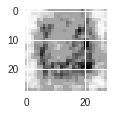

Estimate: [[-2.767284]]
Iteration: 500 at 2018-04-24 13:59:30.681377


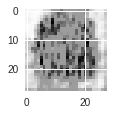

Estimate: [[0.26825315]]
Iteration: 600 at 2018-04-24 13:59:35.827328


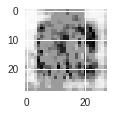

Estimate: [[-3.740459]]
Iteration: 700 at 2018-04-24 13:59:40.996661


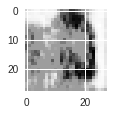

Estimate: [[3.1177058]]
Iteration: 800 at 2018-04-24 13:59:46.295576


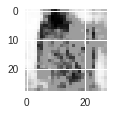

Estimate: [[-0.40407208]]
Iteration: 900 at 2018-04-24 13:59:51.444054


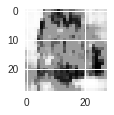

Estimate: [[-3.9144166]]
Iteration: 1000 at 2018-04-24 13:59:56.702653


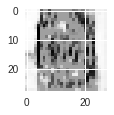

Estimate: [[1.3680646]]
Iteration: 1100 at 2018-04-24 14:00:01.867369


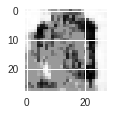

Estimate: [[-4.365078]]
Iteration: 1200 at 2018-04-24 14:00:07.061281


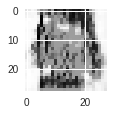

Estimate: [[-2.9977822]]
Iteration: 1300 at 2018-04-24 14:00:12.241124


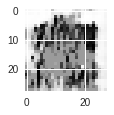

Estimate: [[1.644674]]
Iteration: 1400 at 2018-04-24 14:00:17.416109


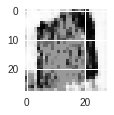

Estimate: [[-3.4899218]]
Iteration: 1500 at 2018-04-24 14:00:22.591435


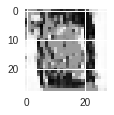

Estimate: [[-3.5622997]]
Iteration: 1600 at 2018-04-24 14:00:27.789676


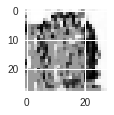

Estimate: [[-6.483724]]
Iteration: 1700 at 2018-04-24 14:00:32.982387


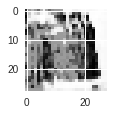

Estimate: [[-2.3548741]]
Iteration: 1800 at 2018-04-24 14:00:38.171250


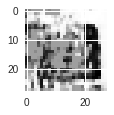

Estimate: [[-2.4305463]]
Iteration: 1900 at 2018-04-24 14:00:43.524762


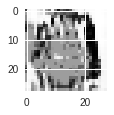

Estimate: [[-6.952161]]
Iteration: 2000 at 2018-04-24 14:00:48.723093


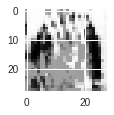

Estimate: [[-1.774225]]
Iteration: 2100 at 2018-04-24 14:00:53.930335


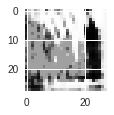

Estimate: [[0.87717295]]
Iteration: 2200 at 2018-04-24 14:00:59.146644


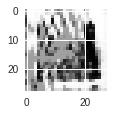

Estimate: [[-3.542788]]
Iteration: 2300 at 2018-04-24 14:01:04.371251


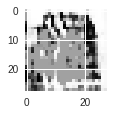

Estimate: [[-11.940731]]
Iteration: 2400 at 2018-04-24 14:01:09.590189


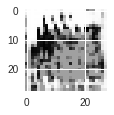

Estimate: [[3.5700881]]
Iteration: 2500 at 2018-04-24 14:01:14.942422


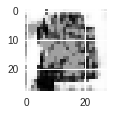

Estimate: [[-0.8102951]]
Iteration: 2600 at 2018-04-24 14:01:20.146496


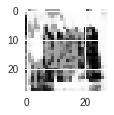

Estimate: [[-4.451949]]
Iteration: 2700 at 2018-04-24 14:01:25.355168


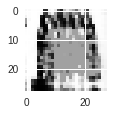

Estimate: [[-1.4844002]]
Iteration: 2800 at 2018-04-24 14:01:30.573963


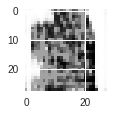

Estimate: [[2.185826]]
Iteration: 2900 at 2018-04-24 14:01:35.791200


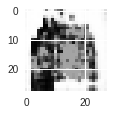

Estimate: [[-5.211817]]
Iteration: 3000 at 2018-04-24 14:01:41.170425


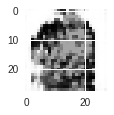

Estimate: [[6.447345]]
Iteration: 3100 at 2018-04-24 14:01:46.385467


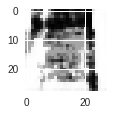

Estimate: [[-3.8715656]]
Iteration: 3200 at 2018-04-24 14:01:51.619943


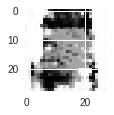

Estimate: [[-7.8306146]]
Iteration: 3300 at 2018-04-24 14:01:56.852682


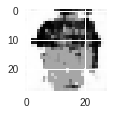

Estimate: [[1.0605246]]
Iteration: 3400 at 2018-04-24 14:02:02.095892


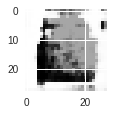

Estimate: [[3.5590804]]
Iteration: 3500 at 2018-04-24 14:02:07.363022


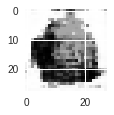

Estimate: [[-1.7077715]]
Iteration: 3600 at 2018-04-24 14:02:12.621629


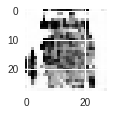

Estimate: [[-12.040719]]
Iteration: 3700 at 2018-04-24 14:02:17.859755


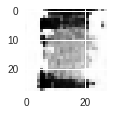

Estimate: [[-0.9509757]]
Iteration: 3800 at 2018-04-24 14:02:23.118929


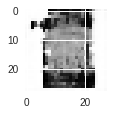

Estimate: [[-0.9382174]]
Iteration: 3900 at 2018-04-24 14:02:28.370666


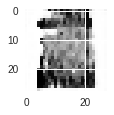

Estimate: [[-0.35887176]]
Iteration: 4000 at 2018-04-24 14:02:33.650742


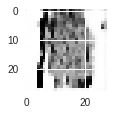

Estimate: [[3.963407]]
Iteration: 4100 at 2018-04-24 14:02:38.989754


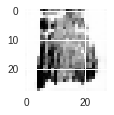

Estimate: [[-4.2384515]]
Iteration: 4200 at 2018-04-24 14:02:44.429766


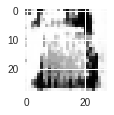

Estimate: [[-5.2411003]]
Iteration: 4300 at 2018-04-24 14:02:49.685402


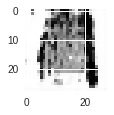

Estimate: [[-10.478436]]
Iteration: 4400 at 2018-04-24 14:02:54.955464


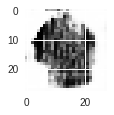

Estimate: [[-1.2531381]]
Iteration: 4500 at 2018-04-24 14:03:00.247351


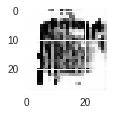

Estimate: [[-1.0450954]]
Iteration: 4600 at 2018-04-24 14:03:05.532139


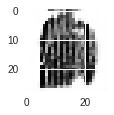

Estimate: [[-5.2595663]]
Iteration: 4700 at 2018-04-24 14:03:10.815579


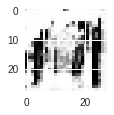

Estimate: [[11.322743]]
Iteration: 4800 at 2018-04-24 14:03:16.097211


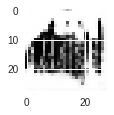

Estimate: [[24.5118]]
Iteration: 4900 at 2018-04-24 14:03:21.373898


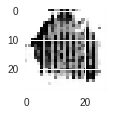

Estimate: [[-1.9414339]]
Iteration: 5000 at 2018-04-24 14:03:26.673941


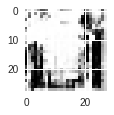

Estimate: [[-20.54192]]
Iteration: 5100 at 2018-04-24 14:03:31.982297


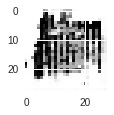

Estimate: [[17.219612]]
Iteration: 5200 at 2018-04-24 14:03:37.319705


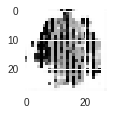

Estimate: [[4.810364]]
Iteration: 5300 at 2018-04-24 14:03:42.645640


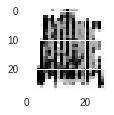

Estimate: [[-13.511412]]
Iteration: 5400 at 2018-04-24 14:03:47.949357


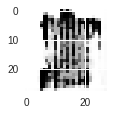

Estimate: [[-1.7638397]]
Iteration: 5500 at 2018-04-24 14:03:53.246960


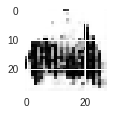

Estimate: [[-3.929965]]
Iteration: 5600 at 2018-04-24 14:03:58.574451


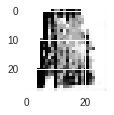

Estimate: [[3.6876829]]
Iteration: 5700 at 2018-04-24 14:04:03.872562


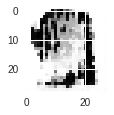

Estimate: [[-16.569908]]
Iteration: 5800 at 2018-04-24 14:04:09.187813


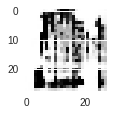

Estimate: [[17.379337]]
Iteration: 5900 at 2018-04-24 14:04:14.500421


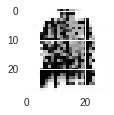

Estimate: [[0.25229818]]
Iteration: 6000 at 2018-04-24 14:04:19.803917


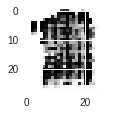

Estimate: [[23.237051]]
Iteration: 6100 at 2018-04-24 14:04:25.108360


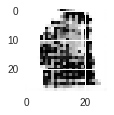

Estimate: [[-1.2303267]]
Iteration: 6200 at 2018-04-24 14:04:30.603709


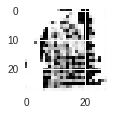

Estimate: [[-25.84982]]
Iteration: 6300 at 2018-04-24 14:04:35.998968


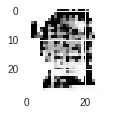

Estimate: [[20.667149]]
Iteration: 6400 at 2018-04-24 14:04:41.346233


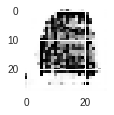

Estimate: [[5.571223]]
Iteration: 6500 at 2018-04-24 14:04:46.704623


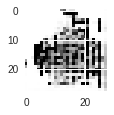

Estimate: [[2.7462456]]
Iteration: 6600 at 2018-04-24 14:04:52.045544


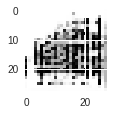

Estimate: [[-15.828559]]
Iteration: 6700 at 2018-04-24 14:04:57.420782


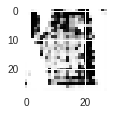

Estimate: [[8.675215]]
Iteration: 6800 at 2018-04-24 14:05:02.760358


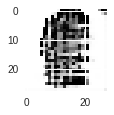

Estimate: [[15.194108]]
Iteration: 6900 at 2018-04-24 14:05:08.110027


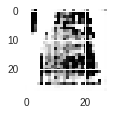

Estimate: [[-4.5014043]]
Iteration: 7000 at 2018-04-24 14:05:13.457299


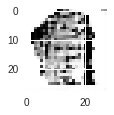

Estimate: [[-0.54434407]]
Iteration: 7100 at 2018-04-24 14:05:18.813968


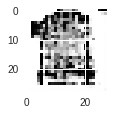

Estimate: [[8.330365]]
Iteration: 7200 at 2018-04-24 14:05:24.183677


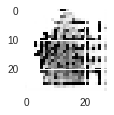

Estimate: [[0.40261012]]
Iteration: 7300 at 2018-04-24 14:05:29.564219


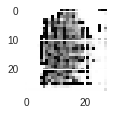

Estimate: [[8.981611]]
Iteration: 7400 at 2018-04-24 14:05:34.984678


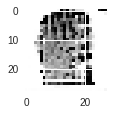

Estimate: [[-44.37187]]
Iteration: 7500 at 2018-04-24 14:05:40.411520


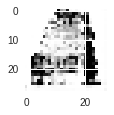

Estimate: [[-38.913326]]
Iteration: 7600 at 2018-04-24 14:05:45.782096


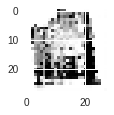

Estimate: [[3.9333858]]
Iteration: 7700 at 2018-04-24 14:05:51.136474


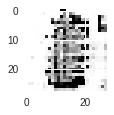

Estimate: [[5.196973]]
Iteration: 7800 at 2018-04-24 14:05:56.517417


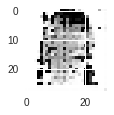

Estimate: [[-4.957447]]
Iteration: 7900 at 2018-04-24 14:06:01.883136


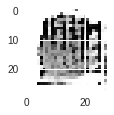

Estimate: [[-15.804578]]
Iteration: 8000 at 2018-04-24 14:06:07.272938


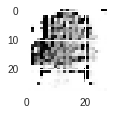

Estimate: [[-2.8797252]]
Iteration: 8100 at 2018-04-24 14:06:12.681066


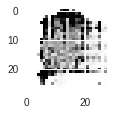

Estimate: [[11.536028]]
Iteration: 8200 at 2018-04-24 14:06:18.071254


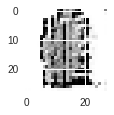

Estimate: [[11.665781]]
Iteration: 8300 at 2018-04-24 14:06:23.465103


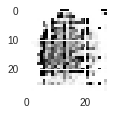

Estimate: [[6.442435]]
Iteration: 8400 at 2018-04-24 14:06:28.882937


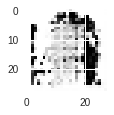

Estimate: [[-17.308031]]
Iteration: 8500 at 2018-04-24 14:06:34.535804


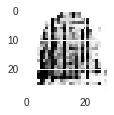

Estimate: [[-9.345132]]
Iteration: 8600 at 2018-04-24 14:06:39.956642


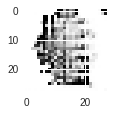

Estimate: [[6.4381957]]
Iteration: 8700 at 2018-04-24 14:06:45.376305


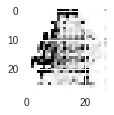

Estimate: [[17.448256]]
Iteration: 8800 at 2018-04-24 14:06:50.773457


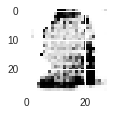

Estimate: [[-0.27748066]]
Iteration: 8900 at 2018-04-24 14:06:56.188763


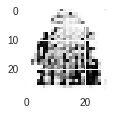

Estimate: [[2.2109547]]
Iteration: 9000 at 2018-04-24 14:07:01.600902


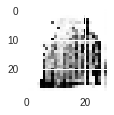

Estimate: [[10.260206]]
Iteration: 9100 at 2018-04-24 14:07:07.009328


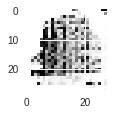

Estimate: [[-6.2288275]]
Iteration: 9200 at 2018-04-24 14:07:12.429775


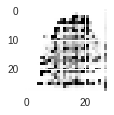

Estimate: [[-14.81945]]
Iteration: 9300 at 2018-04-24 14:07:17.850560


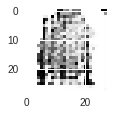

Estimate: [[-28.206017]]


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
plt.figure(figsize=(1,1))

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.figure(figsize=(1.5,1.5))
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)